# Feature importance methods

In [10]:
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from eda import *
from processing import *

In [18]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [19]:
# load all new columns and preprocessing we did before in EDA
pipe = joblib.load('../pipelines/text_pipeline.joblib')
pipe.fit_transform(df_train)
pipe.fit_transform(df_test)

,id,keyword,location,text,count_caps_lock,count_exclamation_mark,count_hashtags,count_words,count_punctuation,count_links,...,positive,anticipation,fear,negative,sadness,disgust,anticip,processed_text,processed_text_str,mention_god_related
0,0,NaN,NaN,Just happened a terrible car crash,0,0,0,6,0,0,...,0,0,1,1,1,0,0,"[happen, terrible, car, crash]",happen terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0,0,1,9,3,0,...,1,0,1,1,1,0,0,"[heard, earthquake, different, city, stay, saf...",heard earthquake different city stay safe ever...,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1,0,0,19,2,0,...,1,0,1,0,0,0,0,"[forest, fire, spot, pond, goose, flee, across...",forest fire spot pond goose flee across street...,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0,0,2,4,3,0,...,1,0,1,1,1,1,1,"[apocalypse, light, spokane, wildfire]",apocalypse light spokane wildfire,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0,0,0,8,0,0,...,1,0,1,1,1,1,1,"[typhoon, soudelor, kill, china, taiwan]",typhoon soudelor kill china taiwan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,7,0,0,8,1,0,...,1,0,1,1,1,1,1,"[earthquake, safety, los, angeles, ûò, safety,...",earthquake safety los angeles ûò safety fasten...,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,2,0,0,23,5,0,...,0,0,0,1,0,0,0,"[storm, ri, bad, last, hurricane, hardest, hit...",storm ri bad last hurricane hardest hit yard l...,0
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,0,0,0,6,5,1,...,1,0,1,1,1,1,1,"[green, line, derailment, chicago]",green line derailment chicago,0
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,2,0,0,7,7,1,...,1,0,1,1,1,1,1,"[meg, issue, hazardous, weather, outlook, hwo]",meg issue hazardous weather outlook hwo,0


## Correlation matrix

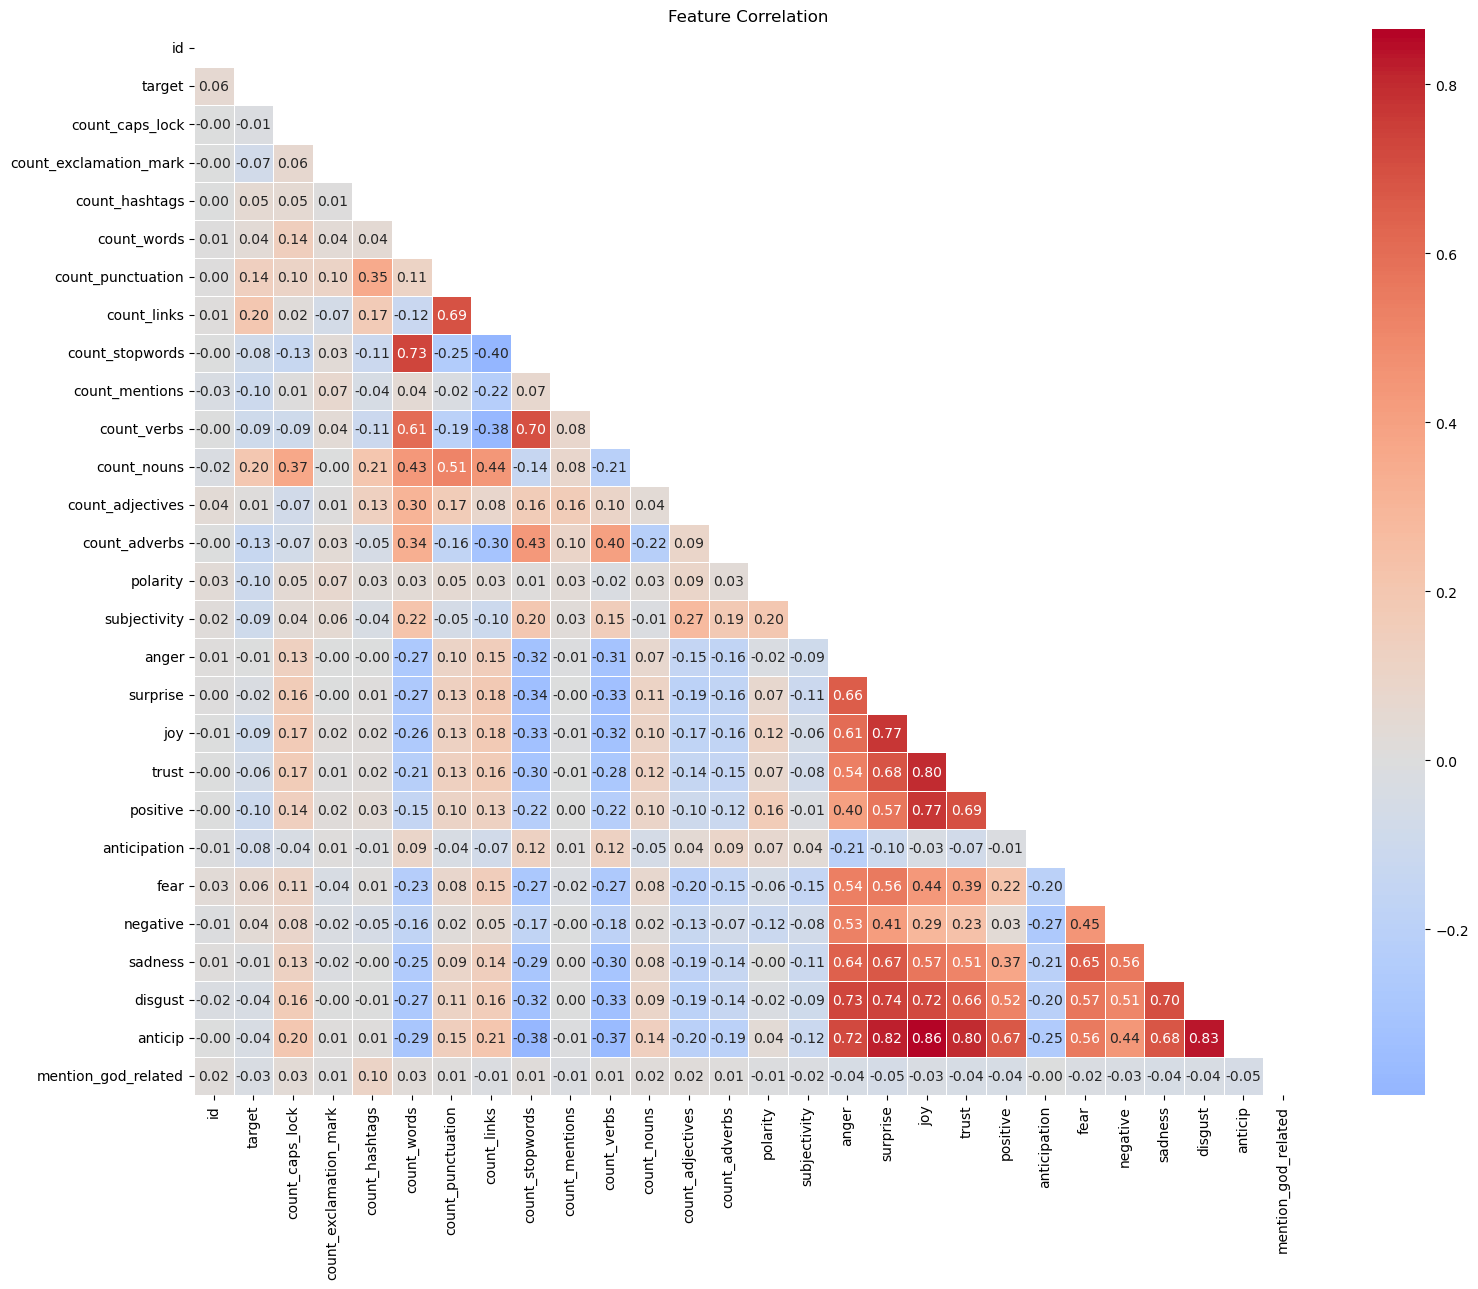

In [20]:
numeric_cols = df_train.select_dtypes(include=['number'])
correlations = numeric_cols.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
plt.figure(figsize=(16,13))
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, mask=mask, center=0)
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()


New added emotions have a high correlation with each other, so we will leave only the ones that have the biggest correlation with the target

We will check the importance of all new added columns to see if any of them can be relevant to the models

## Recursive elimination

Using only new columns (without text) vs target

In [47]:
train_df_new_cols = df_train[['target', 'count_caps_lock', 'count_exclamation_mark',
       'count_hashtags', 'count_words', 'count_punctuation', 'count_links',
       'count_stopwords', 'count_mentions', 'count_verbs', 'count_nouns',
       'count_adjectives', 'count_adverbs', 'polarity', 'subjectivity',
        'positive','fear', 'mention_god_related']]
test_df_new_cols = df_train[['target', 'count_caps_lock', 'count_exclamation_mark',
       'count_hashtags', 'count_words', 'count_punctuation', 'count_links',
       'count_stopwords', 'count_mentions', 'count_verbs', 'count_nouns',
       'count_adjectives', 'count_adverbs', 'polarity', 'subjectivity',
        'positive','fear', 'mention_god_related']]

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
X_train = train_df_new_cols.drop(columns=['target'])
X_test = test_df_new_cols.drop(columns=['target'])
Y_train = train_df_new_cols['target']
Y_test = test_df_new_cols['target']

model = LogisticRegression()
model.fit(X_train,Y_train)
predictions = model.predict(X_test)

f1 = f1_score(predictions, Y_test)
print("f1 score with all columns:" ,f1)


f1 score with all columns: 0.5586760280842528


In [27]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [49]:
rfe = RFE(model, step=1)
result = rfe.fit(X_train, Y_train)
print("Remaining feature number: ", result.n_features_)
print("Feature ranking: ", result.ranking_)

Remaining feature number:  8
Feature ranking:  [ 4  1 10  8  7  1  6  2  9  3  5  1  1  1  1  1  1]


In [50]:
selected_features = pd.DataFrame({"Feature": list(X_train.columns), "Ranking": rfe.ranking_})
selected_features

,Feature,Ranking
0,count_caps_lock,4
1,count_exclamation_mark,1
2,count_hashtags,10
3,count_words,8
4,count_punctuation,7
5,count_links,1
6,count_stopwords,6
7,count_mentions,2
8,count_verbs,9
9,count_nouns,3


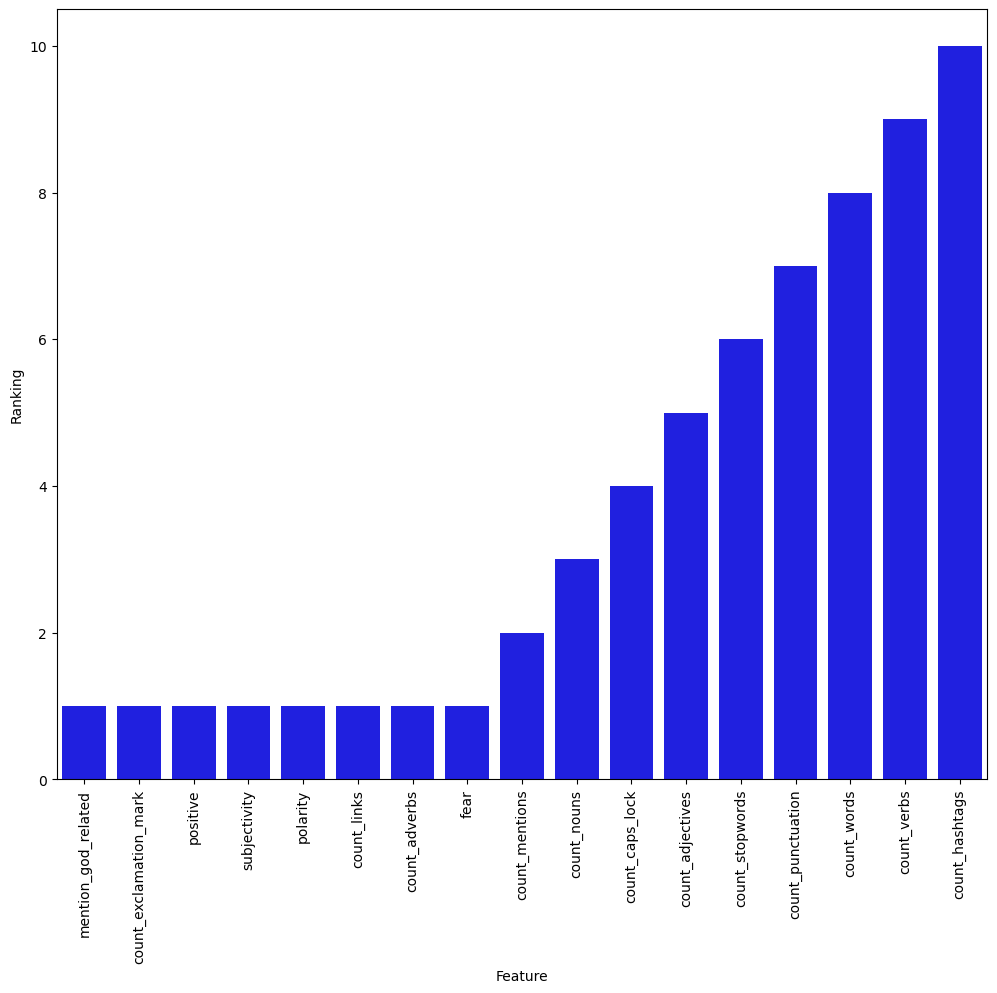

In [51]:
X_sorted = selected_features.sort_values(by='Ranking')
plt.figure(figsize=(12,10))
sns.barplot( x=X_sorted['Feature'], y=X_sorted['Ranking'], color='blue')
plt.xticks(rotation=90)
plt.show()

**According to this method most important new columns are:**
* mention_god_related
* count_exclamation_mark
* positive
* subjectivity
* polarity
* count_links
* count_adverbs
* fear

## Random Forest feature importance

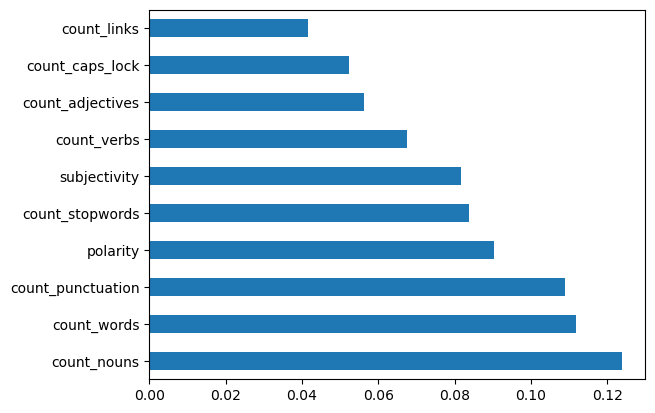

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train,Y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

**The most important features according to Random Forest:**
* count_nouns
* count_words
* count_punctuation
* polarity
* subjectivity
* count_verbs
* count_adjectives
* count_caps_lock
* count_links

These observations correspond more to the conlusions we had from correlation matrix